In [5]:
%load_ext autoreload
%autoreload 1

In [6]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()

import numpy as np
import sys 
sys.path.append("../..") 

%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.manifold import TSNE

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
k_list = [10, 10, 10, 10, 10, 10, 10]
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']
ref_start_year = 2010
ref_end_year = 2021

# Generate a dataframe which contains periodicals' random semantic change

In [17]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, -1, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False
    return nan_in_middle, len_of_1, start_idx, end_idx

In [3]:
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

def cal_local_distance(x, tar_neighbor_idxs, ref_neighbor_idxs, tar_vectors, ref_vectors):
    neighbor_idx_list = list(set(tar_neighbor_idxs[x]).union(set(ref_neighbor_idxs[x])))
    tar_neighbor_vectors = [tar_vectors[idx] for idx in neighbor_idx_list]
    ref_neighbor_vectors = [ref_vectors[idx] for idx in neighbor_idx_list]
    tar_focal_vector = tar_vectors[x]
    ref_focal_vector = ref_vectors[x]

    tar_second_order_change = cosine_similarity(tar_focal_vector.reshape(1,-1), tar_neighbor_vectors)
    ref_second_order_change = cosine_similarity(ref_focal_vector.reshape(1,-1), ref_neighbor_vectors)

    return paired_distances(tar_second_order_change, ref_second_order_change, metric='cosine')[0]

In [8]:
def generate_random_neighbor_idx(n):
    arr = np.zeros((n, 10), dtype=int)  # 创建一个形状为(n, 10)的数组来存储结果
    for i in range(n):
        choices = list(range(0, i)) + list(range(i + 1, n))  # 排除当前行索引i
        arr[i] = np.random.choice(choices, size=10, replace=False)  # 无放回抽样10个数
    return arr

In [13]:
model = p2v.P2V()

random_semantic_change_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_change_1960s', 
                 'semantic_change_1970s', 
                 'semantic_change_1980s',
                 'semantic_change_1990s',
                 'semantic_change_2000s',
                 'semantic_change_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]

    prinT("finish, start generate neighbor union...")
    # old_neighbor_idxs = np.argsort(cosine_similarity(old_vectors, old_vectors))[:, -2:-k_list[i]-2:-1]
    # new_neighbor_idxs = np.argsort(cosine_similarity(new_vectors, new_vectors))[:, -2:-k_list[i+1]-2:-1]
    old_neighbor_idxs = generate_random_neighbor_idx(len(shared_VIDs))
    new_neighbor_idxs = generate_random_neighbor_idx(len(shared_VIDs))
    
    prinT("start cal random neighbor distance...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    dist = dist_df.index.to_series().parallel_apply(cal_local_distance, args=(old_neighbor_idxs, 
                                                                              new_neighbor_idxs, 
                                                                              old_vectors, 
                                                                              new_vectors))
    prinT("finish")

    dist_df[col_name_list[i]] = dist
    random_semantic_change_df = random_semantic_change_df.merge(dist_df, on='VID', how='outer')
    random_semantic_change_df['total_semantic_change_'+new_start_year+'s'] = random_semantic_change_df[col_name_list[0:i+1]].sum(axis=1)

2024-09-26 21:35:04 -- start loading Mag_venue_info_df
2024-09-26 21:35:04 -- finish.
2024-09-26 21:35:04 -- start loading labeled_journal_info_df
2024-09-26 21:35:04 -- finish.
-----------------------
2024-09-26 21:35:04 -- start comparing 1950-1959 with the 1960-1969
2024-09-26 21:35:04 -- start loading word vectors...
2024-09-26 21:35:04 -- word vectors loaded, and its shape is: (1645, 100)
2024-09-26 21:35:04 -- start loading word vectors...
2024-09-26 21:35:04 -- word vectors loaded, and its shape is: (3116, 100)
2024-09-26 21:35:04 -- the number of shared VIDs between this two decades: 1500
2024-09-26 21:35:04 -- finish, start generate neighbor union...
2024-09-26 21:35:05 -- start cal random neighbor distance...
2024-09-26 21:35:06 -- finish
-----------------------
2024-09-26 21:35:06 -- start comparing 1960-1969 with the 1970-1979
2024-09-26 21:35:06 -- start loading word vectors...
2024-09-26 21:35:06 -- word vectors loaded, and its shape is: (3116, 100)
2024-09-26 21:35:06 --

In [14]:
# Labelling
random_semantic_change_df.loc[:,'venue_name'] = random_semantic_change_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
# Using the lastes decade's labels
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
random_semantic_change_df['scopus_label'] = random_semantic_change_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                                                            else np.nan)

2024-09-26 21:37:44 -- start loading VID_labeled...
2024-09-26 21:37:44 -- finish.


In [15]:
# incorrect venues in MAG
corrupted_venue_name_list = ['Japanese Journal of Pharmacology', 
                             'Journal of Computers',
                             'Journal of Algorithms',
                             'Journal of Agricultural Engineering Research',
                             'Sozial-und Praventivmedizin',
                             'Scientia Forestalis',
                             'Interpretation',
                             'Genes',
                             'Protein Science',
                             'Hospital Medicine',
                             'Immunotechnology',
                             'Journal of Ayurveda and Integrative Medicine',
                             'Versus',
                             'Tradition',
                             'ACM Transactions on Cyber-Physical Systems',
                             'Journal of Biomedical Engineering',
                             'Antibiotics and Chemotherapy',
                             'Social Work',
                             'Production Journal',
                             'Insight',
                             'Sats',
                             'English',
                             'Leonardo',
                             'The Forum',
                             'Chemical Industry',
                             'The American review of respiratory disease',
                             'Chemistry & Industry',
                             'Lawrence Berkeley National Laboratory',
                             'international symposium on open collaboration',
                             'Scopus',
                             'Technical reports',
                             'The annual research report',
                             'Biosilico',
                             '0',
                             'Computer Science and Its Applications',
                             'Journal of Programming Languages',
                             'Fuel and Energy Abstracts',
                            ]

In [18]:
# Filtering
random_semantic_change_df = random_semantic_change_df[~(random_semantic_change_df.venue_name.isin(corrupted_venue_name_list))]
random_semantic_change_df[['nan_in_middle', 
                          'len_of_1', 
                          'start_idx', 
                          'end_idx']] = random_semantic_change_df[col_name_list].apply(filter_nan_in_middle, axis=1, result_type='expand')
# Make sure that each time series never interrupts and has a value for the lastest decade
random_semantic_change_df = random_semantic_change_df[(random_semantic_change_df.nan_in_middle==False) & (random_semantic_change_df.end_idx==5)]

In [19]:
# save as .pkl file
random_semantic_change_df.to_pickle('random_semantic_change_k_10.pkl')

# Load the pre-generated DataFrame from the local file

In [13]:
model = p2v.P2V()
random_semantic_change_df = pd.read_pickle('random_semantic_change_k_10.pkl')

2024-09-26 22:54:26 -- start loading Mag_venue_info_df
2024-09-26 22:54:26 -- finish.
2024-09-26 22:54:26 -- start loading labeled_journal_info_df
2024-09-26 22:54:26 -- finish.


# Plot the distribution of periodicals' total semantic change

In [14]:
abbr_dict = {# 1950s
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'Quarterly Journal of Economics': 'QJE', 
             'Econometrica': 'Econometrica', 
             'Psychological Bulletin': 'Psychol. Bull.',
             'Chemical Reviews': 'Chem. Rev.',
             'JAMA': 'JAMA',
             'Science': 'Science',
             'Nature': 'Nature',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'Physical Review Letters': 'PRL',
             'The New England Journal of Medicine': 'NEJM',
             'American Sociological Review': 'ASR',
             'Annals of Mathematics':'Ann. Math.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'Proceedings of The Royal Society B: Biological Sciences': 'Proc. R. Soc. B',
    
             # 1960s
             'Atmosphere':'Atmosphere',
             'Language Learning': 'Lang. Learn.',
             'Automatica': 'Automatica',
             'Materials Research Bulletin': 'Mater. Res. Bull.',
             'Carbon':'Carbon',
             'Stanford Law Review': 'SLR',
             'Computing': 'Computing',
             'Journal of Applied Crystallography': 'J. Appl. Crystallogr.',
             'Ultrasonics': 'Ultrasonics',
             'IEEE Transactions on Nuclear Science': 'IEEE Trans Nucl Sci',
             'IEEE Transactions on Biomedical Engineering': 'IEEE. Trans. Biomed. Eng.',
             'Pattern Recognition': 'Pattern Recognit.',
             'Physics Letters B': 'PLB',
             'Journal of Financial and Quantitative Analysis': 'JFQA',
                
             # 1970s
             'Studies in Second Language Acquisition':'Stud. Second Lang. Acquis.',
             'Linguistic Inquiry': 'Linguist. Inq.',
             'European Journal of Political Research': 'EJPR',
             'Accounting Organizations and Society': 'Account. Organ. Soc.',
             'Clinical Infectious Diseases': 'Clin. Infect. Dis.',
             'Economic Analysis and Policy': 'Econ Anal Policy',
             'Research Policy': 'Res. Policy',
             'Gene': 'Gene',
             'Pain': 'Pain',
             'Social Networks': 'Soc. Netw.',
             'Life sciences in space research': 'Life Sci Space Res',
             'Computational Biology and Chemistry': 'Comput Biol Chem',
             'Civil Engineering': 'C.E.J',
             'Journal of Biosciences': 'J. Biosci.',
             'Cell': 'Cell',
    
             # 1980s
             'Applied Linguistics':'Appl. Linguist.',
             'Journal of Accounting and Economics': 'J. Account. Econ.',
             'Journal of Accounting and Public Policy': 'JAPP',
             'Journal of Physics: Condensed Matter': 'J. Phys. Condens. Matter',
             'Transport Reviews': 'Transp. Rev.',
             'European Management Journal': 'EMJ',
             'International Journal of Remote Sensing': 'Int. J. Remote Sens.',
             'Stem Cells': 'Stem Cells',
             'Journal of Chemometrics': 'J. Chemom.',
             'Bioelectromagnetics': 'Bioelectromagnetics',
             'neural information processing systems': 'NeurIPS',
             'IEEE Transactions on Medical Imaging': 'IEEE TMI',

             # 1990s
             'The Accounting Review': 'Account. Rev.',
             'Human Resource Management Journal': 'Hum. Resour. Manag. J.',
             'Cancer Cell': 'Cancer Cell',
             'IEEE Transactions on Applied Superconductivity': 'IEEE TAS',
             'Cell Research': 'Cell Res.',
             'the web conference': 'TheWebConf',
             'knowledge discovery and data mining': 'KDD',
             'empirical methods in natural language processing': 'EMNLP',
             'Materials': 'Materials',
             'Sensors': 'Sensor',
             'Complexity': 'Complexity',

             # 2000s
             'PLOS ONE': 'PLOS ONE',
             'Nature Reviews Immunology': 'Nat. Rev. Immunol.',
             'Nature Materials': 'Nat. Mater',
             'Lancet Oncology': 'Lancet Oncol.',
             'Nature Photonics': 'Nat. Photonics',
             'Obesity': 'Obesity',
             'Nature Chemical Biology': 'Nat. Chem. Biol.',
             'IEEE Transactions on Industrial Informatics': 'IEEE TII',
             'BMC Research Notes': 'BMC Res. Notes',
            }

display(random_semantic_change_df[(random_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(random_semantic_change_df.start_idx==0)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(random_semantic_change_df[(random_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(random_semantic_change_df.start_idx==1)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(random_semantic_change_df[(random_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(random_semantic_change_df.start_idx==2)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(random_semantic_change_df[(random_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(random_semantic_change_df.start_idx==3)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(random_semantic_change_df[(random_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(random_semantic_change_df.start_idx==4)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(random_semantic_change_df[(random_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(random_semantic_change_df.start_idx==5)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))

,venue_name,total_semantic_change_2010s
27015,Proceedings of The Royal Society B: Biological Sciences,0.499049
337,Science,0.427500
11531,Nature,0.360339
10533,Proceedings of the National Academy of Sciences of the United States of America,0.316192
3408,Chemical Reviews,0.311808
10556,CA: A Cancer Journal for Clinicians,0.296822
2105,Physical Review Letters,0.253634
7878,Econometrica,0.229855
14421,JAMA,0.213798
3810,Annals of Mathematics,0.212925


,venue_name,total_semantic_change_2010s
14077,Ultrasonics,0.476050
454,IEEE Transactions on Biomedical Engineering,0.323243
6552,Journal of Applied Crystallography,0.323136
15774,Carbon,0.302728
1229,IEEE Transactions on Nuclear Science,0.273283
13467,Stanford Law Review,0.272993
29,Pattern Recognition,0.267036
4241,Automatica,0.231258
6823,Language Learning,0.224549
14529,Physics Letters B,0.197891


,venue_name,total_semantic_change_2010s
8670,Computational Biology and Chemistry,0.459455
5392,Journal of Biosciences,0.322343
1284,Civil Engineering,0.321579
26892,Economic Analysis and Policy,0.211319
11773,Pain,0.184657
2232,Social Networks,0.176998
9163,Cell,0.176424
6276,Gene,0.176393
11324,European Journal of Political Research,0.155260
741,Linguistic Inquiry,0.146290


,venue_name,total_semantic_change_2010s
4802,IEEE Transactions on Medical Imaging,0.385598
6505,Bioelectromagnetics,0.383181
5114,Journal of Chemometrics,0.224771
5390,Stem Cells,0.170805
17806,neural information processing systems,0.160476
15345,Applied Linguistics,0.132473
9807,International Journal of Remote Sensing,0.113230
7170,Journal of Accounting and Public Policy,0.099716
15959,Journal of Physics: Condensed Matter,0.085735
8737,European Management Journal,0.072579


,venue_name,total_semantic_change_2010s
8414,Sensors,0.226235
10752,Cell Research,0.164518
17352,Complexity,0.153045
1579,Materials,0.132053
9959,IEEE Transactions on Applied Superconductivity,0.131035
17855,knowledge discovery and data mining,0.084216
18712,empirical methods in natural language processing,0.082244
2181,Cancer Cell,0.076921
17931,the web conference,0.073040
9442,Human Resource Management Journal,0.069196


,venue_name,total_semantic_change_2010s
16927,PLOS ONE,0.063958
8576,Nature Materials,0.053665
7705,Nature Reviews Immunology,0.051644
4236,Nature Chemical Biology,0.040750
8262,BMC Research Notes,0.039018
10076,Nature Photonics,0.038176
9758,Lancet Oncology,0.035042
2528,Obesity,0.028217
15421,IEEE Transactions on Industrial Informatics,0.026588


<Figure size 1920x1440 with 0 Axes>

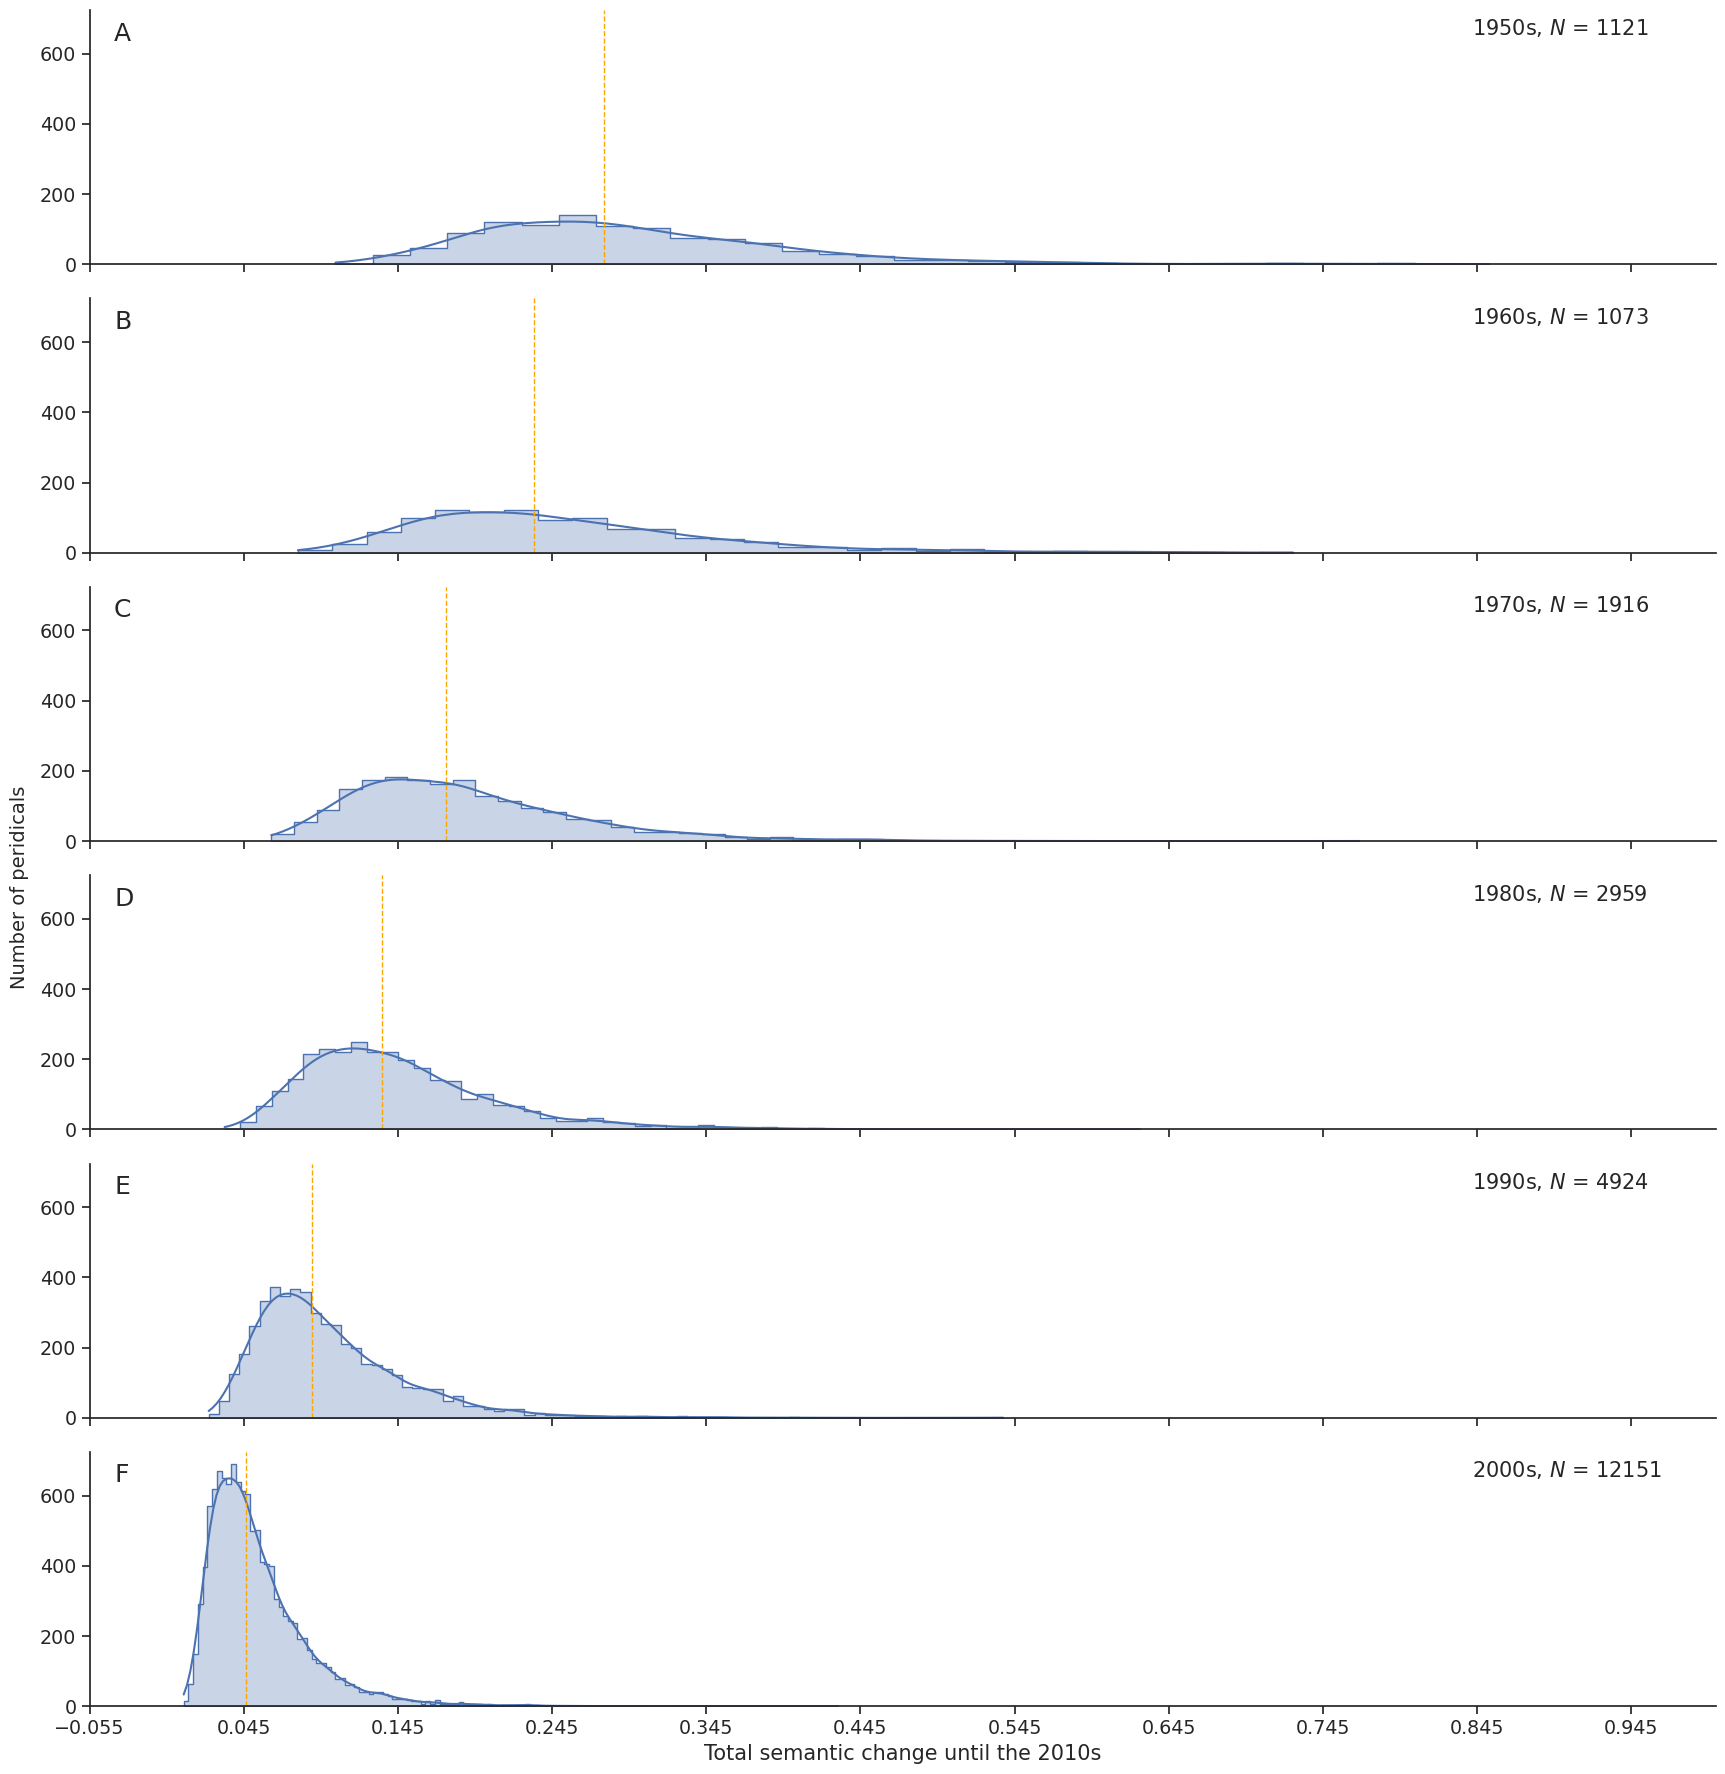

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

def annotate_n_and_decade(data, **kws):
    n = len(data)
    start_year = start_year_list[data.start_idx.unique()[0]]
    ax = plt.gca()
    ax.text(0.85, .9, f"{start_year}s, $N$ = {n}", transform=ax.transAxes)

def plot_median(x, **kwargs):
    ax = plt.gca()
    ax.axvline(x.median(), c='orange', ls='--', lw=1)

def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        TSC = row.total_semantic_change_2010s
        median = data.total_semantic_change_2010s.median()
        venue_name = row.venue_name

        if TSC <= median:
            c = 'y'
            alpha = (median - TSC) / median
        if TSC > median:
            c = 'g'
            alpha = (TSC - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Science', 'Psychological Bulletin', 'Nature', 'Physical Review Letters', 
                          'Proceedings of the National Academy of Sciences of the United States of America', 
                          'The Lancet',
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Physics Letters B', 
                          'Journal of Financial and Quantitative Analysis',
                          'Atmosphere', 
                          # 1970s
                          'Linguistic Inquiry', 'Gene', 'Social Networks', 
                          'Civil Engineering', 'Journal of Biosciences',
                          # 1980s
                          'Journal of Chemometrics', 'Bioelectromagnetics',
                          'IEEE Transactions on Medical Imaging', 'Journal of Accounting and Economics', 
                          # 1990s
                          'The Accounting Review', 'Cell Research', 'Materials', 'Sensors', 'Complexity',
                          # 2000s
                          'Lancet Oncology', 'BMC Research Notes', 'IEEE Transactions on Industrial Informatics',
                         ]:
            label_y = 250
        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'Econometrica', 'The New England Journal of Medicine', 
                          'Proceedings of The Royal Society B: Biological Sciences', 'BMJ',
                          # 1960s
                          'Language Learning', 'Journal of Applied Crystallography', 'Pattern Recognition', 
                          # 1970s
                          'Studies in Second Language Acquisition', 'Computational Biology and Chemistry', 'Cell', 'Research Policy',
                          'Economic Analysis and Policy', 
                          # 1980s
                          'neural information processing systems', 'Applied Linguistics', 
                          # 1990s
                          'Human Resource Management Journal', 'the web conference', 
                          # 2000s
                          'Nature Reviews Immunology', 'PLOS ONE', 
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'JAMA', 'American Sociological Review', 
                          # 1960s
                          'Ultrasonics', 'Automatica', 'IEEE Transactions on Nuclear Science', 
                          # 1970s
                          'Life sciences in space research', 'European Journal of Political Research', 'Pain', 
                          # 1980s
                          'Journal of Accounting and Public Policy', 'Transport Reviews', 'Stem Cells',
                          'European Management Journal', 
                          # 1990s
                          'Cancer Cell', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Materials', 'Nature Chemical Biology',
                         ]:
            label_y = 550
        # ultra high
        if venue_name in [# 1950s
                          'Chemical Reviews', 'Psychological Bulletin', 
                          # 1960s
                          'IEEE Transactions on Biomedical Engineering', 'Materials Research Bulletin',
                          # 1970s
                          'Accounting Organizations and Society', 
                          'Clinical Infectious Diseases', 
                          # 1980s
                          'Journal of Physics: Condensed Matter', 'International Journal of Remote Sensing',
                          # 1990s
                          'knowledge discovery and data mining', 'IEEE Transactions on Applied Superconductivity',
                          # 2000s
                          'Nature Photonics', 'Obesity',
                          ]:
            label_y = 700
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'Quarterly Journal of Economics', 'BMJ', 'Physical Review Letters', 
                          'Proceedings of The Royal Society B: Biological Sciences', 'Science', 
                          # 1960s
                          'Carbon', 'Materials Research Bulletin', 'Physics Letters B', 
                          # 1970s
                          'Gene', 'Research Policy',
                          'Civil Engineering', 'Cell',
                          # 1980s
                          'Stem Cells', 'Bioelectromagnetics', 'European Management Journal', 
                          'neural information processing systems', 
                          # 1990s
                          'Complexity', 'Cell Research', 'Materials',
                         # 2000s

                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = TSC
            haligh = 'center'
            
        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians',
                              'Chemical Reviews', 'The Lancet', 'Nature', 'JAMA', 
                              # 1960s
                              'IEEE Transactions on Biomedical Engineering', 'Journal of Applied Crystallography', 
                              'Pattern Recognition', 'Computing', 'Ultrasonics', 
                              'Stanford Law Review', 
                              # 1970s
                              'Accounting Organizations and Society', 'Social Networks', 'Computational Biology and Chemistry', 
                              'Economic Analysis and Policy', 'Life sciences in space research', 'Journal of Biosciences', 
                              # 1980s
                              'Transport Reviews', 
                              'Journal of Chemometrics', 'Journal of Physics: Condensed Matter', 
                              # 1990s
                              'the web conference', 'Cancer Cell', 'Sensors', 'IEEE Transactions on Applied Superconductivity', 
                              # 2000s
                              'Obesity', 'Nature Chemical Biology', 'IEEE Transactions on Industrial Informatics', 'PLOS ONE', 
                              'BMC Research Notes',
                             ]:
                label_x = TSC + 0.0045
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Econometrica', 'Annals of Mathematics', 'Psychological Bulletin', 
                              'The New England Journal of Medicine', 'Journal of Financial and Quantitative Analysis', 
                              'American Sociological Review', 
                              # 1960s
                              'Atmosphere', 'IEEE Transactions on Nuclear Science', 'Automatica', 'Language Learning',
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 
                              'European Journal of Political Research',
                              'Clinical Infectious Diseases', 'Pain', 
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'IEEE Transactions on Medical Imaging',
                              'Journal of Accounting and Public Policy', 'International Journal of Remote Sensing',
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 
                              'empirical methods in natural language processing', 'knowledge discovery and data mining', 
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Photonics', 
                              
            ]: 
                label_x = TSC - 0.0045
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(abbr_dict[venue_name], xy=(TSC, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=15, bbox = bbox_props, arrowprops = arrow_props)

plt.figure(dpi=300)
sns.set(style='white', font_scale=1.25)
g2 = sns.FacetGrid(random_semantic_change_df, 
                   row="start_idx", height=3, aspect=6, margin_titles=True)
g2.tick_params(axis='both', bottom='on',left='on')
g2.set(xlim=(-0.05, 1), xticks=np.arange(-0.055, 1, 0.1), yticks=np.arange(0, 1000, 200))

g2.map_dataframe(sns.histplot, x="total_semantic_change_2010s", kde=True, element='step', alpha=0.3)
g2.map(plot_median, 'total_semantic_change_2010s')
g2.map_dataframe(annotate_n_and_decade)
# g2.map_dataframe(annotate_periodical_name, data=random_semantic_change_df, opaque_value=1)

panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i in range(g2.axes.flatten().shape[0]):
    ax = g2.axes.flatten()[i]
    ax.set_ylabel('')
    ax.text(0.015, .88, panel_labels[i], fontsize=18, transform=ax.transAxes)
    
g2.set_titles(row_template='')
g2.set_axis_labels('Total semantic change until the 2010s')
g2.fig.supylabel('Number of peridicals', x=0.01, fontsize=14)

plt.show()

# Sampling

## Generate data

In [56]:
import random

def pad_list_with_none(lst, target_length=6):
    print('padding length:', target_length - len(lst))
    padding = [None] * (target_length - len(lst))  # generate None list
    return padding + lst  # padding from left

start_idxs = [0, 1, 2, 3, 4]
period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
               'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
n_iter = 1000
all_age_group_result_df = pd.DataFrame(columns=['founded decade', 
                                       '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])
founded_1950_result_df = pd.DataFrame(columns=['1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])

for start_idx in start_idxs:
    print(f'processing {start_year_list[start_idx]}s')
    sampling_df = random_semantic_change_df[random_semantic_change_df.start_idx==start_idx].copy()
    sampling_df.drop(columns=['total_semantic_change_1960s', 'total_semantic_change_1970s', 'total_semantic_change_1980s',
                              'total_semantic_change_1990s', 'total_semantic_change_2000s', 'total_semantic_change_2010s'], inplace=True)
    median_original = random_semantic_change_df[random_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s.median()
    all_period_median_list = []
    if start_idx == 0:
        all_period_mean_list = []

    for period in period_list[start_idx:]:
        print('period to drop:', period)
        column_to_drop = period
        change_df = sampling_df.copy()
        change_df.drop(period, axis=1, inplace=True)

        remain_columns = period_list.copy()
        remain_columns.remove(period)
        print('remain columns:', remain_columns)

        bootstrap_results = []
        print('start iterating...')
        for i in range(n_iter):
            random_change = random.choice(remain_columns)
            change_df[column_to_drop] = change_df[random_change] # use random change to replace the dropped column
            change_df['total_semantic_change_2010s'] = change_df[period_list].sum(axis=1)
            bootstrap_results.append(change_df['total_semantic_change_2010s'].tolist())

        bootstrap_results = np.array(bootstrap_results) # median of all periodials, shape: (n_iter, n_periodicals)
        bootstrap_medians = np.median(bootstrap_results, axis=1)
        bootstrap_medians_diff = median_original - bootstrap_medians # shape: (n_iter,)

        all_period_median_list.append(bootstrap_medians_diff)
        if start_idx == 0:
            # store the average of all bootstrap sample, shape: (n_periodicals,)
            all_period_mean_list.append(np.mean(bootstrap_results, axis=0)) 
            
    print('length of generate data:', len(all_period_median_list))
    all_period_median_list = pad_list_with_none(all_period_median_list)

    # creat a new row
    new_row = pd.DataFrame({
        'founded decade': [start_year_list[start_idx]],
        '1960s': [all_period_median_list[0]],
        '1970s': [all_period_median_list[1]],
        '1980s': [all_period_median_list[2]],
        '1990s': [all_period_median_list[3]],
        '2000s': [all_period_median_list[4]],
        '2010s': [all_period_median_list[5]]
    })

    # use pd.concat() to add the new row to the DataFrame
    all_age_group_result_df = pd.concat([all_age_group_result_df, new_row], ignore_index=True)
    print('\n')

processing 1950s
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...
period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start i

## Plot separately

Number of periodicals: 1121


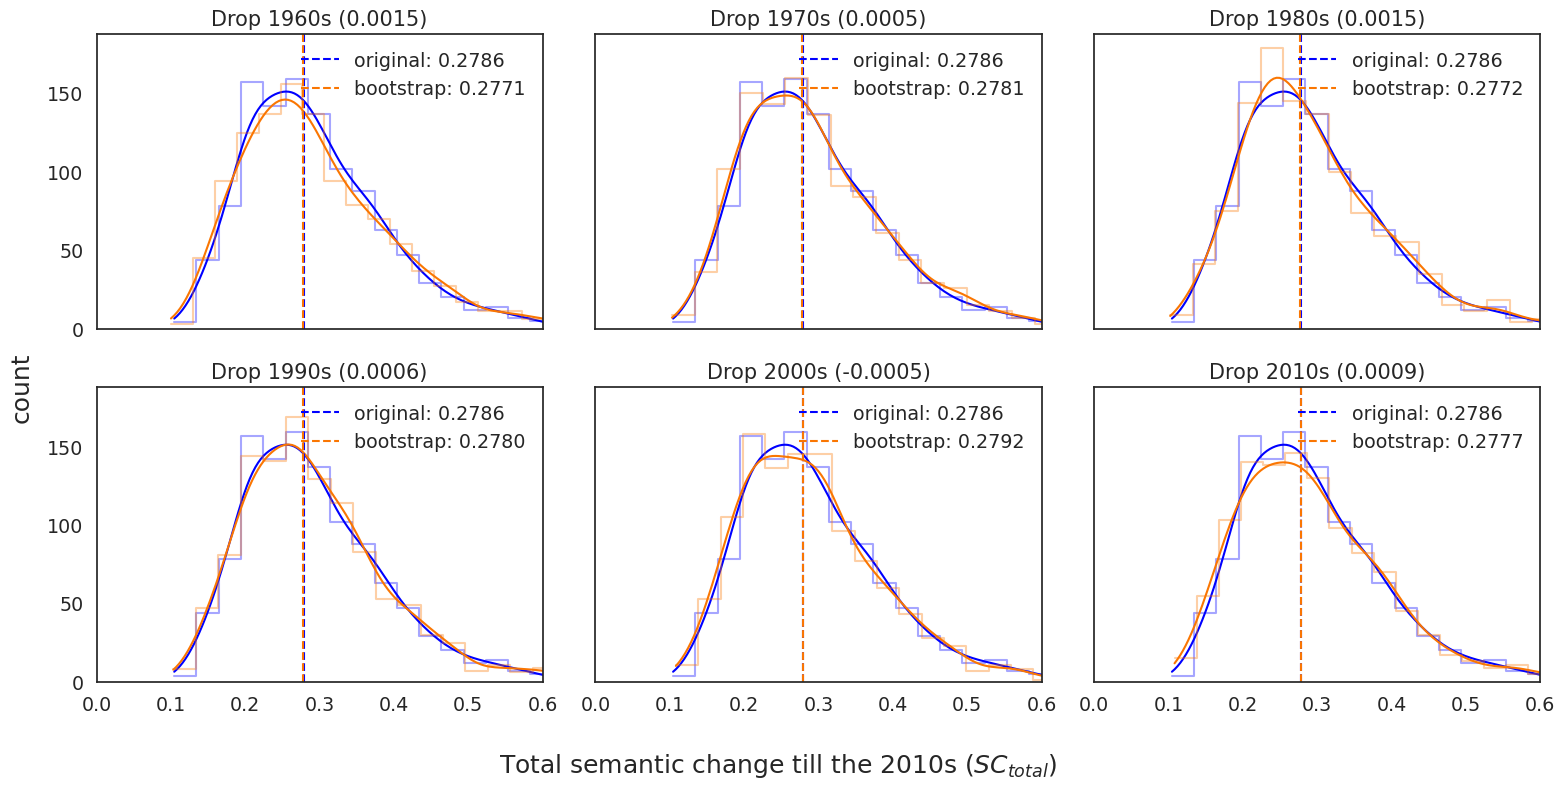

In [57]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
start_idx = 0

# plot distributions period by period
for i, data in enumerate(all_period_mean_list):
    row, col = divmod(i, 3) # calculate row and column index

    sns.histplot(random_semantic_change_df[random_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s, 
                 kde=True, ax=axes[row][col], binwidth=0.03, alpha=0.35, element="step", color='blue', fill=False)
    sns.histplot(data, kde=True, ax=axes[row][col], binwidth=0.03, alpha=0.35, element="step", color='#fa7602', fill=False)

    # indicate median value in the histogram
    median_original = random_semantic_change_df[random_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s.median()
    median = np.median(data) 
    axes[row][col].axvline(median_original, color='blue', linestyle='--', label=f'original: {median_original:.4f}')
    axes[row][col].axvline(median, color='#fa7602', linestyle='--', label=f'bootstrap: {median:.4f}') 

    median_diff = median_original - median
    if median_diff > 0.005:
        axes[row][col].annotate('', xy=(median, 20), xytext=(median_original, 20), 
                     arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        axes[row][col].text((median+median_original)/2+0.027, 10, f'$\Delta med(SC_{{total}})$ = {median_diff:.4f}', color='red', ha='center', va='center')
    
    axes[row][col].set_xlim(0, 0.6)

    axes[row][col].set_title(f'Drop {period_list[i][-5:]} ({median_diff:.4f})')
    axes[row][col].set_xlabel('')
    axes[row][col].set_ylabel('')
    axes[row][col].legend(frameon=False)

print('Number of periodicals:', len(random_semantic_change_df[random_semantic_change_df.start_idx==start_idx]))

fig.supxlabel('Total semantic change till the 2010s ($SC_{total}$)')
fig.supylabel('count')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2710465/2022925361.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

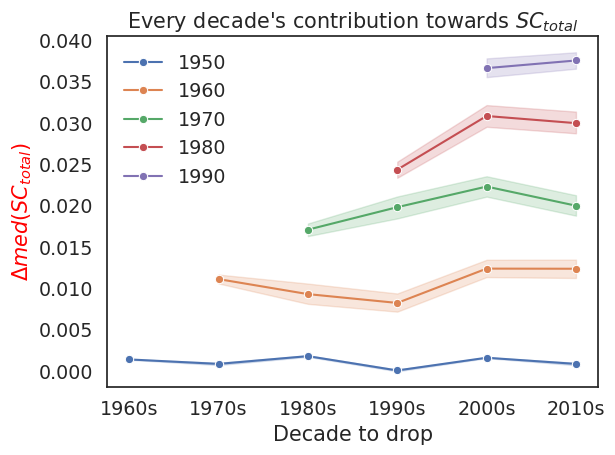

In [59]:
plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for decade in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
    for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
        if all_age_group_result_df[decade][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [decade] * len(all_age_group_result_df[decade][idx]),
                'Value': all_age_group_result_df[decade][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[decade][idx])
            })
        plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

plt.figure()
sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', errorbar='ci', marker='o')

plt.title('Every decade\'s contribution towards $SC_{total}$')
plt.xlabel('Decade to drop')
plt.ylabel('$\Delta med(SC_{total})$', color='red')
plt.legend(frameon=False)
plt.tight_layout()

plt.show()

## Plot togather

/tmp/ipykernel_2710465/859022297.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset 

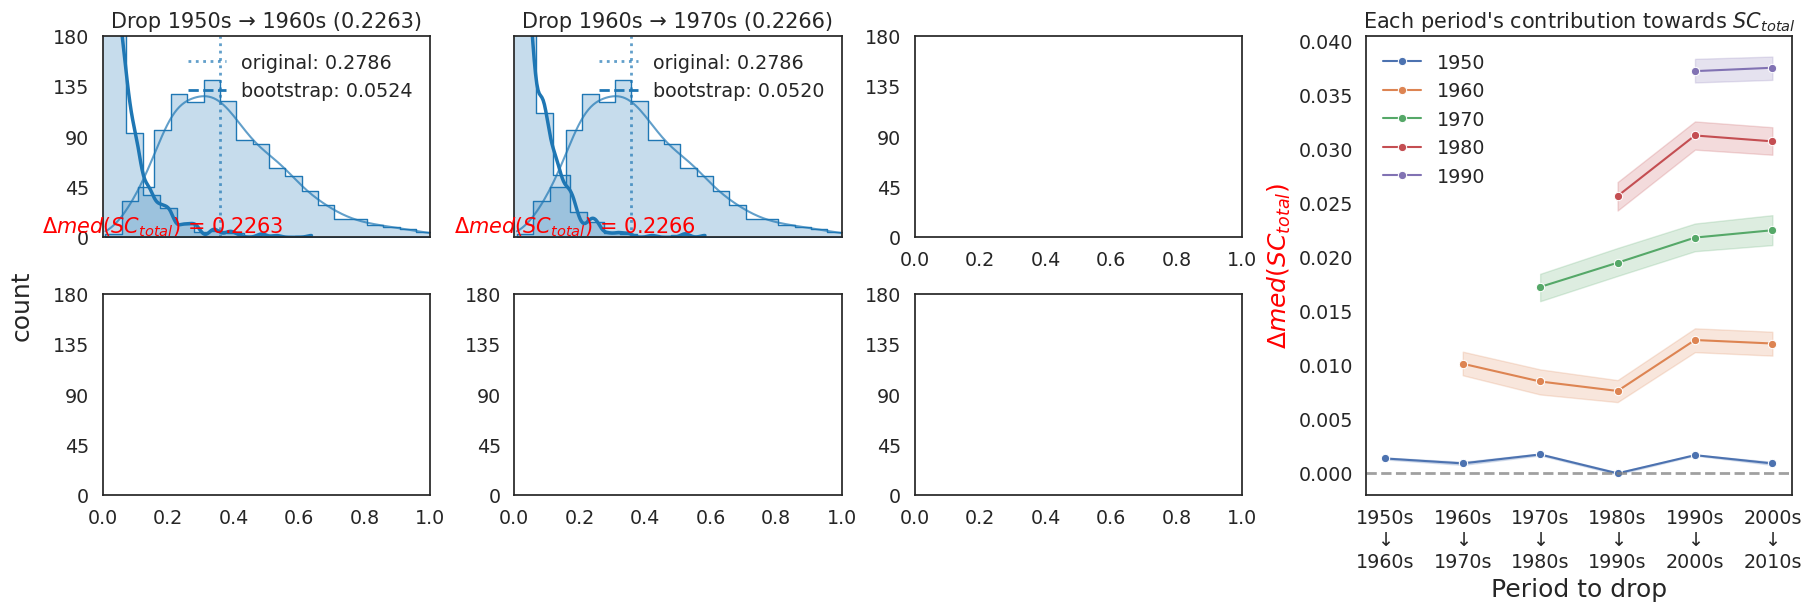

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# creat a figure with 2 rows and 4 columns, the first 3 columns for the first plot, the last column for the second plot
fig = plt.figure(figsize=(18, 6), constrained_layout=True)
grid = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1.3], hspace=0.01, wspace=0.01)  # more space for the second plot

# manully set the y-axis range and ticks
y_min, y_max = 0, 180
yticks = np.linspace(y_min, y_max, 5)

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
title_period = ['1950s → 1960s', '1960s → 1970s','1970s → 1980s','1980s → 1990s','1990s → 2000s','2000s → 2010s']

# axes of the first plot
axes = []
for row in range(2):
    for col in range(3):
        ax = fig.add_subplot(grid[row, col])
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(yticks)
        axes.append(ax)

# the first plot: plot distributions period by period
start_idx = 0
for i, data in enumerate(all_period_mean_list):
    row, col = divmod(i, 3)  # calculate row and column index

    ax = axes[i]
    sns.histplot(random_semantic_change_df[random_semantic_change_df.start_idx == start_idx].total_semantic_change_2010s,
                 kde=True, ax=ax, binwidth=0.025, alpha=0.25, line_kws={'alpha': 0.7}, element="step", color='#1f77b4', fill=True)
    sns.histplot(data, kde=True, ax=ax, binwidth=0.025, alpha=0.25, line_kws={'lw': 2.5}, element="step", color='#1f77b4', fill=True)

    # indicate median value in the histogram
    median_original = random_semantic_change_df[random_semantic_change_df.start_idx == start_idx].total_semantic_change_2010s.median()
    median = np.median(data)
    ax.axvline(median_original, color='#1f77b4', alpha=0.7, linestyle='dotted', lw=2, label=f'original: {median_original:.4f}')
    ax.axvline(median, color='#1f77b4', linestyle='--', lw=2, label=f'bootstrap: {median:.4f}')

    median_diff = median_original - median
    if median_diff > 0.005:
        ax.annotate('', xy=(median, 20), xytext=(median_original, 20),
                                arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        ax.text((median + median_original) / 2 + 0.027, 10, f'$\Delta med(SC_{{total}})$ = {median_diff:.4f}', color='red', ha='center', va='center')

    # adjust axis labels and ticklabels
    ax.set_ylabel('')
    if row == 1 and col == 1:
        ax.set_xlabel('Total semantic change till the 2010s ($SC_{total}$)', fontsize='larger')
    else:
        ax.set_xlabel('')
    if row != 1:
        ax.set_xticklabels([])
    if col != 0:
        ax.set_yticklabels([])
    
    ax.set_xlim(0.1, 0.6)
    ax.set_title(f'Drop {title_period[i]} ({median_diff:.4f})')
    ax.legend(frameon=False)

# create a super title for the first plot
fig.supylabel('count')

# the second plot: plot line chart
ax2 = fig.add_subplot(grid[:, 3])  # the second plot taks the whole last column

plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for decade in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
    for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
        if all_age_group_result_df[decade][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [decade] * len(all_age_group_result_df[decade][idx]),
                'Value': all_age_group_result_df[decade][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[decade][idx])
            })
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', errorbar='ci', marker='o', ax=ax2)
ax2.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

ax2.set_title('Each period\'s contribution towards $SC_{total}$')
ax2.set_xlabel('Period to drop', fontsize='larger')
ax2.set_xticklabels(xticks_v)
ax2.set_ylabel('$\Delta med(SC_{total})$', color='red', fontsize='larger')
ax2.legend(frameon=False)

plt.show()